### This notebook does the following
#### -- It generates a sky spectrum in Temperature vs frequency units over 2-4 GHz assuming a power law model of the sky
#### -- It assumes a sine^theta beam
#### -- At this moment antenna is assumed to be perfectly matched
#### -- It uses 3 input maps that are pre-prepared at spot frequencies and 5 deg resolution (3072 pixels in Healpix format
#### -- It uses an intensity vs frequency file for the CRR prediction 
#### -- Mimics for N spectra (vs time) the sky spectrum at a specific location and UTC -- with or without the CRR lines included
#### -- Calibration from intensity to temperature units assuming RJ correction, CMB temperature etc are all included

#### Pre requisite packages and files to run this notebook
#### healpy, numpy, matplotlib, math, astropy, ephem, pandas, scipy, os
#### total_new_spec.txt, map_408_r4_5deg_nested_galactic_Kelvin.txt, map_1420_r4_5deg_nested_galactic_Kelvin.txt, map_23000_r4_5deg_nested_galactic_Kelvin.txt

In [1]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import math
import os

%matplotlib inline

import ephem
from astropy.time import Time
from astropy.coordinates import Galactic, SkyCoord, FK5, EarthLocation, AltAz, Angle
import astropy.units as u
from astropy.timeseries import TimeSeries, BinnedTimeSeries
from astropy.time import Time, TimeDelta
from scipy.optimize import curve_fit
import pandas as pd
from scipy.interpolate import Rbf, InterpolatedUnivariateSpline
from datetime import datetime
from matplotlib import rc, rcParams
from tqdm import tqdm
import time

### Place the path to all the input and output files in your local machine

In [2]:
file_input_path = '/home/msrao/Workspace/L1_RRIDistortionLab/L2_APSERa/L3_APSERa_data/apsera_spectra_simulations'
file_output_path = '/home/msrao/Workspace/L1_RRIDistortionLab/L2_APSERa/L3_APSERa_data/apsera_spectra_simulations'

### Define necessary constants and corrections (if any)

In [3]:
## correction_150offset = 21.4; // Kelvin, Patra et al. 2015
## correction_150scaling = 1.05; // Patra et al. 2015
TCMB = 2.72548 # Kelvin
h = 6.62607157e-34
k = 1.3806488e-23
c = 2.99792458e+08

#### Some Unit conversions between temperature and spectral radiance in various limits

In [4]:
def T_to_spectral_radiance_planck(freq_GHz,T):     #Freq in GHz
    return (2 * h * freq_GHz**3 * 1e+27 / c**2) / (np.exp((h * freq_GHz* 1e+9) / (k * T)) - 1)
def T_to_spectral_radiance_RJ(freq_GHz,T):     #Freq in GHz
    return (T * 2 * k * freq_GHz**2 * 1e+18 / c**2) 
def spectral_radiance_to_T_RJ(freq_GHz,I_nu):     #Freq in GHz
    return ((I_nu * c**2)/( 2 * k * freq_GHz**2 * 1e+18 )) 

### Define instrument / experiment parameters

In [5]:
f_start = 2  # GHz              
f_stop = 4  #GHz
f_res = 0.001   # GHz 
N_SIDE = 16                   #Healpy parameter: resolution of the map is defined by the NSIDE parameter, which is generally a power of 2.
T_hot = 300
T_cold = 77                    #T_cold and T_hot in Kelvins (for atmospheric corrections to calculate noise added) purposefully taken to be a few thousands
latitude = 13.067439
longitude =80.237617            #Latitude and longitude in degrees
altitude = 0                     #Altitude in meters
alpha = 0.0065                   #Temp. lapse rate (deg C per meter); related to atmospheric corrections
PI = 3.14159265
Noise_int_time = 3e+13
Trx = 30                        # Receiver temperature in Kelvin
T_atm = 1                       # Noise temp added by atmosphere 
freq = np.arange(f_start, f_stop, f_res)
freq_res_Hz = (freq[1]-freq[0])*1e9 # Hz
No_of_Channels = np.size(freq)
#create arrays 
CMB_Int = np.empty([No_of_Channels])
P_hot = np.empty([No_of_Channels])
P_cold = np.empty([No_of_Channels])
P_dif = np.empty([No_of_Channels])
NPIX = hp.nside2npix(N_SIDE)
print("Number of pixels for NSIDE ",N_SIDE," is ",NPIX)
print(
    "Approximate resolution at NSIDE {} is {:.2} deg".format(
        N_SIDE, hp.nside2resol(N_SIDE, arcmin=True) / 60
    )
)

#sky temperature in real and noise temperature stored in imaginary part
sigma = np.zeros([No_of_Channels])     #noise per channel
sigma_noCRR = np.zeros([No_of_Channels])
antenna_temp = np.zeros([No_of_Channels])
antenna_temp_noCRR = np.zeros([No_of_Channels])
noise_temp = np.zeros([No_of_Channels])
noise_temp_noCRR = np.zeros([No_of_Channels])
beam_weight = np.zeros([No_of_Channels,NPIX])

## Some defaults that can be changed later
n_spectra = 1                  #Number of spectra to be taken
delta_t_in_hours = 1/60   #Time step between consecutive spectra in hours

#Refraction correction formula
def refraction(alt_in_deg, altitude):
    alt_in_deg = np.asarray(alt_in_deg)
    pres = 1010.*math.pow((1-6.5/288000*altitude),5.255)
    if (altitude>11000):
        temp = 211.5
    else:
        temp = 283.0 - (alpha * altitude)
    R = 1.02/math.tan((alt_in_deg + (10.3/(alt_in_deg + 5.11)))*(PI/180))
    if (alt_in_deg == 90):
        R = R+ 0.0019279
    tpcor = (pres/1000) * (283/temp)
    R =  tpcor*(R/60)
    return alt_in_deg +R

# Obs = ephem.Observer()
# #print(Obs)
# t = Time(Time_in_UTC, scale='utc',location= EarthLocation(lat = latitude*u.deg, lon=longitude*u.deg, height=altitude*u.m))
# lst = t.sidereal_time('apparent')
# print(lst)

#alt == theta angle; az == phi angle; both in degrees
def beam_def(freq, alt, az):
    if (alt<=0):
        return 0
    else:
        return (math.sin(alt*PI/180)*math.sin(alt*PI/180))


Number of pixels for NSIDE  16  is  3072
Approximate resolution at NSIDE 16 is 3.7 deg


In [6]:
# Ask the user for a time
user_input = input("Enter UTC time (YYYY-MM-DD HH:MM), or press Enter to use system time as UTC: ")

if user_input.strip() == "":
    # Use system time
    my_time = datetime.now()
    print("Using system time:", my_time)
else:
    # Parse the user-provided time
    try:
        my_time = datetime.strptime(user_input, "%Y-%m-%d %H:%M")
        print("Using user-provided time:", my_time)
    except ValueError:
        print("Invalid format! Please use YYYY-MM-DD HH:MM")
Time_in_UTC = my_time
start_time_in_UTC = datetime.strftime(Time_in_UTC, "%Y-%m-%d %H:%M:%S")

UTC_start_time = Time(start_time_in_UTC, format = 'iso', scale= 'utc')

def get_n_spectra(prompt="Enter number of spectra or hit enter for 1 spectrum ", default=n_spectra):
    try:
        # Ask for input
        user_input = input(prompt)

        # If input is empty -> use default
        if user_input.strip() == "":
            print(f"No input provided. Using default value: {default}")
            return default

        # Try converting to integer
        value = int(user_input)

        # Check if it is a natural number
        if value > 0:
            print(f"Using user-provided value: {value}")
            return value
        else:
            print(f"Invalid input. Using default value: {default}")
            return default

    except ValueError:
        # Handles non-integer input
        print(f"Invalid input (not an integer). Using default value: {default}")
        return default

def get_delta_t(prompt="Enter timestep between spectra (in hours), default is 1/60 ", default=delta_t_in_hours):
    try:
        # Ask for input
        user_input = input(prompt)

        # If input is empty -> use default
        if user_input.strip() == "":
            print(f"No input provided. Using default value: {default}")
            return default

        # Try converting to float
        value = float(user_input)

        # Check if it is positive
        if value > 0:
            print(f"Using user-provided value: {value}")
            return value
        else:
            print(f"Invalid input (not positive). Using default value: {default}")
            return default

    except ValueError:
        # Handles non-numeric input
        print(f"Invalid input (not a number). Using default value: {default}")
        return default

# Example usage
n_spectra = get_n_spectra(default=1)
delta_t_in_hours = get_delta_t(default=delta_t_in_hours)
spectrum_UTC_time = TimeSeries(time_start= start_time_in_UTC, time_delta= delta_t_in_hours *u.hour, n_samples= n_spectra)
spectrum_UTC_time = spectrum_UTC_time.time
print('*********************')
print('')
print('Start UTC',UTC_start_time)
print("number of spectra to generate", n_spectra)
print("time-step in hours", delta_t_in_hours)
print('UTC time stamps of spectra',spectrum_UTC_time)
print('')
print('*********************')

Enter UTC time (YYYY-MM-DD HH:MM), or press Enter to use system time as UTC: 
Using system time: 2025-09-16 17:08:55.226419
Enter number of spectra or hit enter for 1 spectrum 
No input provided. Using default value: 1
Enter timestep between spectra (in hours), default is 1/60 
No input provided. Using default value: 0.016666666666666666
*********************

Start UTC 2025-09-16 17:08:55.000
number of spectra to generate 1
time-step in hours 0.016666666666666666
UTC time stamps of spectra ['2025-09-16 17:08:55.000']

*********************


In [7]:
spectra = np.zeros([n_spectra,No_of_Channels])
spectra_noise = np.zeros([n_spectra,No_of_Channels])
spectra_noCRR = np.zeros([n_spectra,No_of_Channels])
spectra_noise_noCRR = np.zeros([n_spectra,No_of_Channels])

### Read input sky maps apply corrections

In [8]:
sky_408 = np.loadtxt(os.path.join(file_input_path, 'map_408_r4_5deg_nested_galactic_Kelvin.txt')) 
sky_1420 = np.loadtxt(os.path.join(file_input_path,'map_1420_r4_5deg_nested_galactic_Kelvin.txt'))
sky_23000 = np.loadtxt(os.path.join(file_input_path,'map_23000_r4_5deg_nested_galactic_Kelvin.txt'))

sky_408 = sky_408-TCMB
sky_1420 = sky_1420 - TCMB
print("Got 408MHz, 1420MHz and 23000MHz maps for power law fitting, and applied necessary corrections!")

Got 408MHz, 1420MHz and 23000MHz maps for power law fitting, and applied necessary corrections!


### Generate the sky model -- option to save the model to a file in the file_output_path.
#### Fit the 3 input maps with a power law at each pixel, normalized to the first frequency. Obtain the spectral index
#### The power law is $T(\nu) = T_{\text{norm}} \left(\frac{\nu}{\nu_{\text{norm}}}\right)^{-\alpha}$.
#### Fit in log log mode $$ \log(T(\nu)) = \log(T_{\text{norm}}) - \alpha \, \log\!\left(\frac{\nu}{\nu_{\text{norm}}}\right)$$
#### Improvement needed - save the chisquare / goodness of fit as a second column in the output file

In [9]:
power_law_model = os.path.join(file_output_path,"fitted_power_law_indices.txt")
# Example frequency array
input_freq = np.array([0.408, 1.420, 23.0])   # GHz

# Example data arrays (replace with your real T1, T2, T3)
T1 = sky_408
T2 = sky_1420
T3 = sky_23000

# Stack temperature arrays -> shape (3072, 3)
T_all = np.vstack([T1, T2, T3]).T  # (rows=index, cols=freq)

alphas = []

for row in T_all:
    # y values for this index
    y_vals = row  
    # Reference normalization (first freq, first T1 value for this index)
    x_norm = input_freq[0]
    y_norm = row[0]

    # log-log fit: log(y/y_norm) = -alpha * log(x/x_norm)
    logx = np.log(input_freq / x_norm)
    logy = np.log(y_vals / y_norm)

    # Linear fit slope = -alpha
    slope, _ = np.polyfit(logx, logy, 1)
    alpha = -slope
    alphas.append(alpha)

alphas = np.array(alphas)

# Save as a text file (one column of alphas)
np.savetxt(power_law_model, alphas, fmt="%.4f")

print("Fitting done. Saved to fitted_power_law_indices.txt in output path")


Fitting done. Saved to fitted_power_law_indices.txt in output path


#### Read the spectral indices derived from fitting temperatures at each pixel (saved in the output path) and generate a power law curve for any pixel number defined in the variable pixel_number. Plot this fit along with raw data in a scatter plot to test/see goodness of fit.

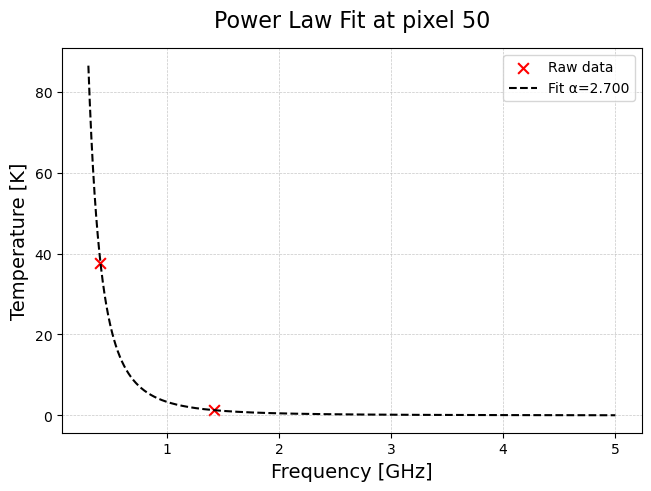

In [10]:
power_law_model = os.path.join(file_output_path,"fitted_power_law_indices.txt")

# Load fitted alphas
alphas = np.loadtxt(power_law_model)

# Example frequency array (must be same as used in fitting)
input_freq = np.array([0.408, 1.420, 23.0]) #GHz

# Example data arrays (replace with your real T1, T2, T3)
T1 = sky_408
T2 = sky_1420
T3 = sky_23000

# Pick an index to plot
pixel_number = 50  
alpha = alphas[pixel_number]
x_norm = input_freq[0]
y_norm = T1[pixel_number]

# Generate fit curve
#f_test_fit = np.logspace(-0.5,1.5,3000)
f_test_fit = np.linspace(0.3,5,3000)
T_fit = y_norm * (f_test_fit / x_norm) ** (-alpha)

# Plot
#plt.scatter([input_freq[0],input_freq[1],input_freq[2]], [T1[pixel_number],T2[pixel_number],T3[pixel_number]], marker="x", s=60, label='Raw data',c='r')  
fig, ax = plt.subplots(constrained_layout=True)
ax.scatter([input_freq[0],input_freq[1]], [T1[pixel_number],T2[pixel_number]], marker="x", s=60, label='Raw data',c='r')  
ax.plot(f_test_fit, T_fit, c='k', ls='--',label=f"Fit α={alpha:.3f}")
#plt.xscale("log")
#plt.yscale("log")
ax.set_xlabel("Frequency [GHz]", fontsize=14 )
ax.set_ylabel("Temperature [K]",fontsize=14)
# Formatting
ax.set_title("Power Law Fit at pixel %d"%pixel_number, fontsize=16, pad=15)
ax.grid(True, which="both", ls="--", lw=0.5, alpha=0.7)
ax.legend(fontsize=10)
plt.show()


### The cell below uses the computed power law fit coefficients and generates the T_sky at every pixel over 2-4 GHz with 1 MHz resolution
### Saves the output to a file called powerlaw_sky_2_4_GHz_1MHz_res_3072pixels.txt
### This cell can also be run one time and not generated every single time we run the notebook, comment out after running once for saving time!

In [11]:
# # Read the sky model
# sky_model = os.path.join(file_input_path,"power_law_model_loglog.txt")

# # New x-values for prediction
# x_new = np.arange(2,4,0.001)

# # Load the saved model parameters
# df = pd.read_csv(sky_model, sep="\t")

# # Create a DataFrame to store predictions
# pred_df = pd.DataFrame(columns=["Index"] + [f"x={v}" for v in x_new])

# for _, row in df.iterrows():
#     idx = int(row["Index"])
#     m = row["Slope(m)"]
#     A = row["Coefficient(A)"]

#     y_pred = A * (x_new ** m)

#     # Append to DataFrame
#     pred_df.loc[len(pred_df)] = [idx] + list(y_pred)
# output_sky_2_4_GHz = os.path.join(file_output_path,"powerlaw_sky_2_4_GHz_1MHz_res_3072pixels.txt")
# # Save to text file with tab separation
# pred_df.to_csv(output_sky_2_4_GHz, sep="\t", index=False)

# print("Computed sky model saved to powerlaw_sky_2_4_GHz_1MHz_res_3072pixels.txt")


In [12]:
recomb_file = os.path.join(file_input_path,'total_spec_new.dat')
df = pd.read_csv(recomb_file,sep= "    " ,header = None)
df.reset_index(drop=True, inplace=True)
df.columns = ["Frequency","Intensity"]
x = df["Frequency"]
y= df["Intensity"]
ius = InterpolatedUnivariateSpline(x, y)   #1-D interpolating spline for a given set of data points; default k=3 being cubic spline
CRR_Int = ius(freq)

/tmp/ipykernel_2255204/2269072952.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(recomb_file,sep= "    " ,header = None)


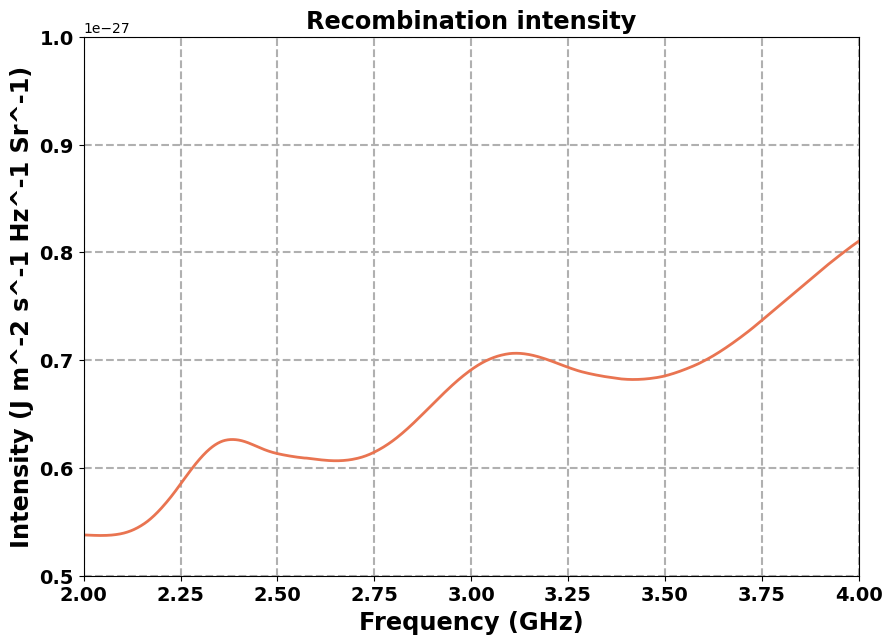

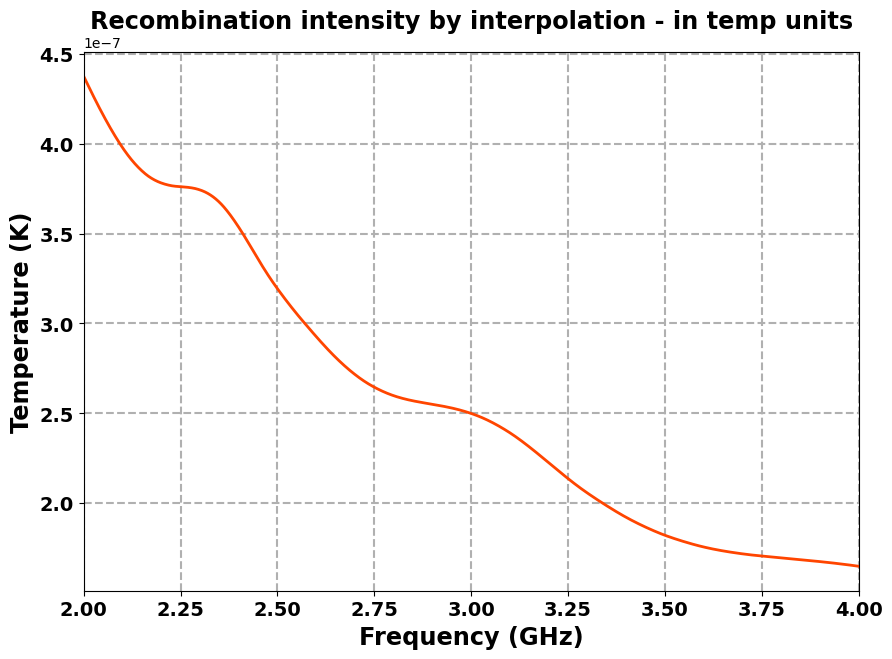

In [13]:
plt.figure(figsize=(10, 7))
#plt.plot((df['Frequency']), (df['Intensity']),linewidth=2)
plt.plot(freq, CRR_Int,linewidth=2,color='#E97451') #orangered')
plt.title('Recombination intensity', fontsize='xx-large', fontweight='bold')
plt.xlabel('Frequency (GHz)', fontsize='xx-large', fontweight='bold')
plt.ylabel('Intensity (J m^-2 s^-1 Hz^-1 Sr^-1)', fontsize='xx-large', fontweight='bold')
plt.xlim([f_start,f_stop])
plt.ylim([0.5e-27,1e-27])
plt.xticks(fontsize = 14, fontweight='bold')
plt.yticks(fontsize = 14, fontweight='bold')
plt.grid(linewidth=1.5, linestyle='--')
plt.show()


#In terms of temperature
temp_recom=((c**2)*CRR_Int)/(2*k*(freq**2)*1e18)
plt.figure(figsize=(10, 7))
plt.title('Recombination intensity by interpolation - in temp units', fontsize='xx-large', fontweight='bold')
plt.plot(freq, temp_recom,linewidth=2,color='orangered')
plt.xlabel('Frequency (GHz)', fontsize='xx-large', fontweight='bold')
plt.ylabel('Temperature (K)', fontsize='xx-large', fontweight='bold')
plt.xlim([f_start,f_stop])
# plt.ylim([0.5e-27,1e-27])
plt.xticks(fontsize = 14, fontweight='bold')
plt.yticks(fontsize = 14, fontweight='bold')
plt.grid(linewidth=1.5, linestyle='--')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Got P_dif for calibration!


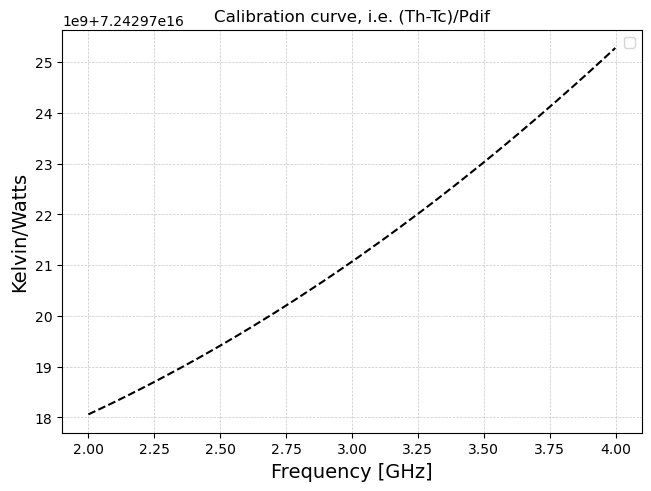

In [14]:
#P_hot and P_cold for calibration using Planck formula for spectral density of available noise power from resistor - per channel
## Ref - see eqn 3 of paper here : https://tsapps.nist.gov/publication/get_pdf.cfm?pub_id=904009
P_hot = (freq_res_Hz*h*freq*1e9)/(np.exp((h*freq*1e9)/(k*T_hot))-1)
P_cold = (freq_res_Hz*h*freq*1e9)/(np.exp((h*freq*1e9)/(k*T_cold))-1)
P_dif = P_hot - P_cold
#print(P_hot)
print("Got P_dif for calibration!")
calibration_curve = (T_hot-T_cold)/P_dif
fig, ax = plt.subplots(constrained_layout=True)
ax.plot(freq,calibration_curve,c='k', ls='--')  
#plt.xscale("log")
#plt.yscale("log")
ax.set_xlabel("Frequency [GHz]", fontsize=14 )
ax.set_ylabel("Kelvin/Watts",fontsize=14)
# Formatting
ax.set_title("Calibration curve, i.e. (Th-Tc)/Pdif")
ax.grid(True, which="both", ls="--", lw=0.5, alpha=0.7)
ax.legend(fontsize=10)
plt.show()

### Calculate CMB spectral radiance over all frequencies

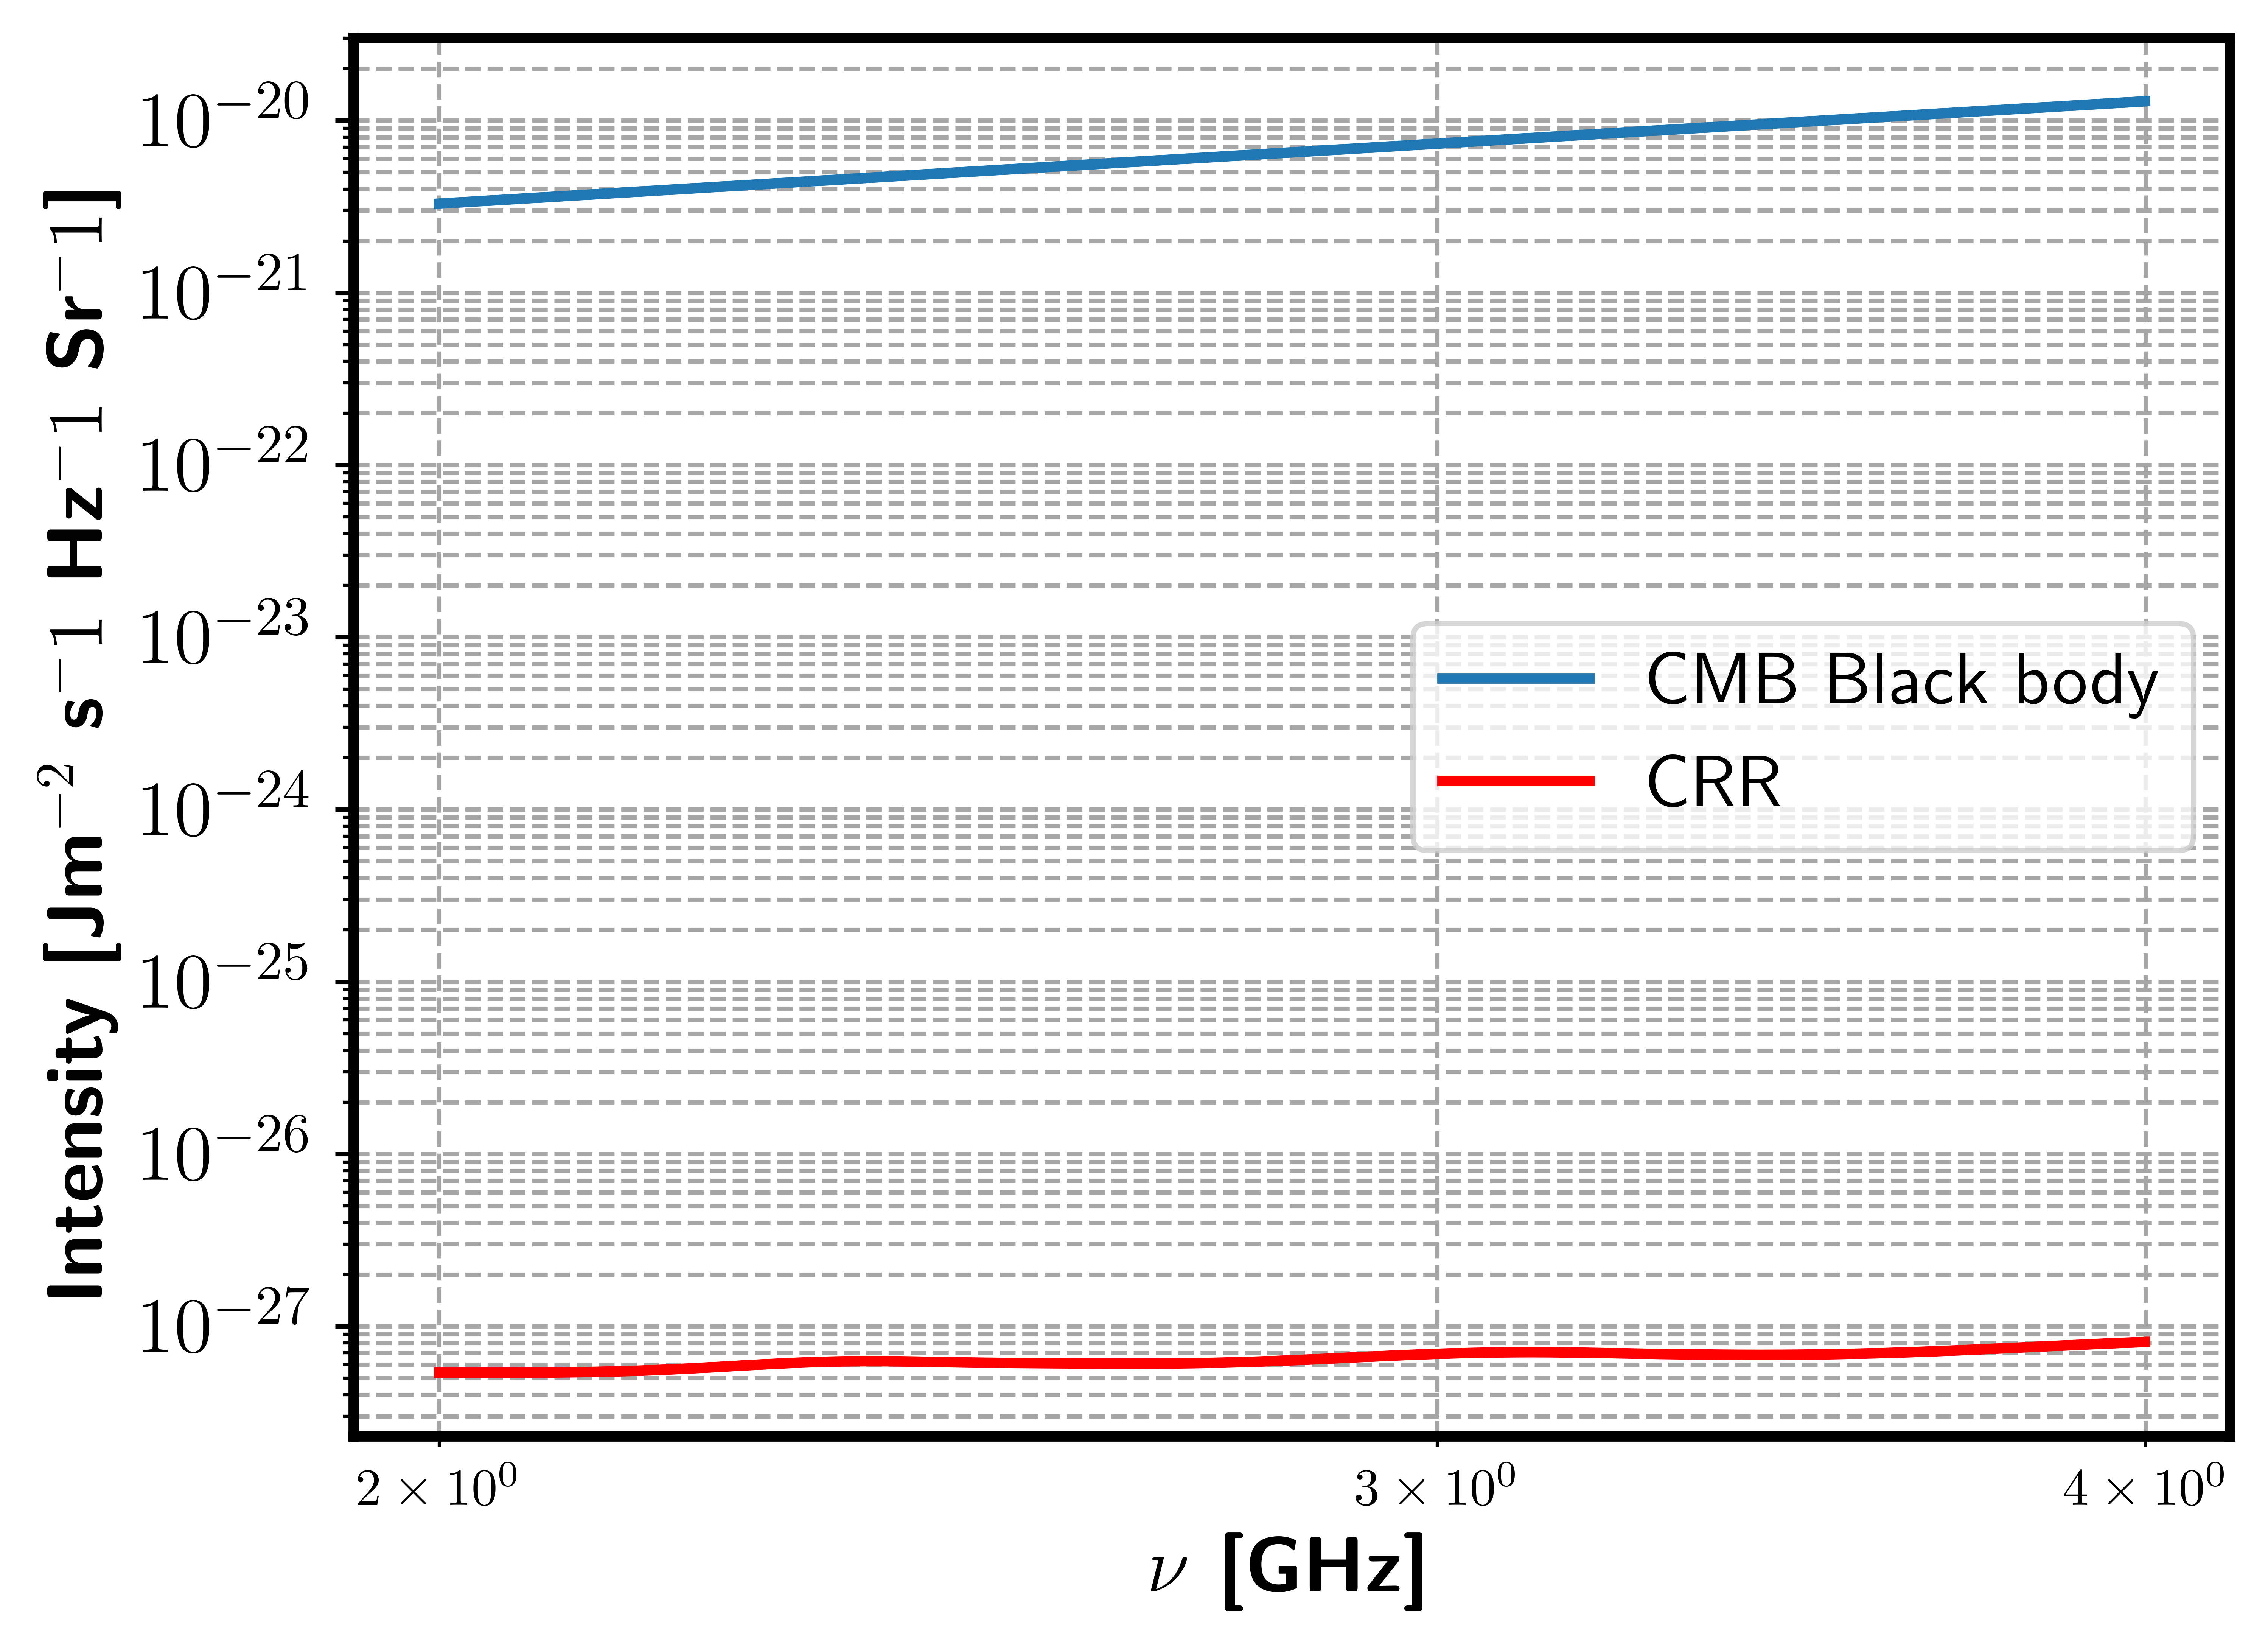

In [15]:
CMB_Int = T_to_spectral_radiance_planck(freq,TCMB)
#ax= plt.subplot()
plt.figure(dpi=1000)
plt.rcParams['text.usetex'] = True
rc('axes', linewidth=2)
rc('font', weight='bold')
plt.grid(True,which="both",ls="--",color='0.65')
plt.plot(freq, CMB_Int, label = "CMB Black body",lw=2)
plt.plot(freq, CRR_Int, label = "CRR",lw=2,c='r')
plt.loglog()
plt.legend(fontsize=14,)
plt.ylabel(r'\textbf{Intensity [Jm$^{-2}$ s${^-1}$ Hz${^-1}$ Sr${^-1}$]}',fontsize=15)
plt.xlabel(r'\textbf{$\nu$ [GHz]}',fontsize=15)
plt.tick_params(labelsize=15)
ax.set_xticks(x)
ax.set_yticks(y)
ax.set_xticklabels(x, fontweight='bold')
ax.set_yticklabels(y, fontweight='bold')
plt.show()

### Put everything together to get sky spectra!

In [16]:
# sky_2_4_GHz = os.path.join(file_output_path,"powerlaw_sky_2_4_GHz_1MHz_res_3072pixels.txt")
# df_sky = pd.read_csv(sky_2_4_GHz, sep="\t")
# arr = df_sky.drop(columns=["Index"]).to_numpy()

In [17]:
pixel_indices = np.arange(0,3072)
coords = hp.pixelfunc.pix2ang(16, pixel_indices , nest = True, lonlat = True)          #pix2ang = gives l and b coordinates for each pixel; NSIDE=16 
gc = SkyCoord(l = coords[0]*u.degree, b= coords[1]*u.degree, frame = 'galactic') 
print(np.shape(coords))
print(np.shape(gc))

(2, 3072)
(3072,)


### Please note some notations and conversions used
1. 2 types of spectra generated -- default is with CRR. The one without CRR is explicitly stated as _noCRR
2. All values calculated per pixel and per freq have in their name _at_pix_freq
3. To convert beween spectral radiance to power we use the formula below, where $$\Delta f$$ is the channel resolution or bandwidth
$$
P = \frac{I_\nu \, c^2}{2 \, \nu^2} \, \Delta f
$$

In [18]:
power_law_model = os.path.join(file_output_path,"fitted_power_law_indices.txt")

# Load fitted alphas
alphas = np.loadtxt(power_law_model)

# Example frequency array (must be same as used in fitting)
input_freq = np.array([0.408, 1.420, 23.0]) #GHz
f_norm = input_freq[0]
# Example data arrays (replace with your real T1, T2, T3)
T_norm = sky_408

spectrum_number = 0
for spectrum_number in tqdm(range(n_spectra), desc="Processing spectra"):
    equi = gc.transform_to(AltAz(obstime = spectrum_UTC_time[spectrum_number], location = EarthLocation(lat = latitude*u.deg, lon=longitude*u.deg , height=altitude*u.m)))
    alt = equi.alt.value
    pixel_number=0
    while pixel_number<NPIX:           #Working on each pixel
        new_alt = refraction(alt[pixel_number], altitude)
        alpha = alphas[pixel_number]
        #Now, the coordinates in Galactic frame is changed to equitorial frame below
        #print(freq)
        channel_number=0
        longitudes = equi.az.value
        while channel_number< No_of_Channels:
            #if (longitudes>359.00):
            #    longitudes = 359.00
            cwt = beam_def(freq[channel_number], new_alt, longitudes)   #beam weight
            beam_weight[channel_number,pixel_number] = cwt   ## Save to a 2D array to collapse later
            #print(new_alt,cwt)
            if (cwt>0):     #Adding all the three intensities
                sky_temp_at_pixel_freq = T_norm[pixel_number] * ((freq[channel_number] / f_norm) ** (-alpha))
                foreground_spectral_radiance = T_to_spectral_radiance_RJ(freq[channel_number],sky_temp_at_pixel_freq)        
                spectral_radiance_at_pix_freq = foreground_spectral_radiance + CMB_Int[channel_number] + CRR_Int[channel_number]
                spectral_radiance_noCRR_at_pix_freq = foreground_spectral_radiance + CMB_Int[channel_number]
                power_at_pix_freq = (spectral_radiance_at_pix_freq *(c*c)* freq_res_Hz) /(1e+18* freq[channel_number]**2)
                power_noCRR_at_pix_freq = (spectral_radiance_noCRR_at_pix_freq * (c*c) * freq_res_Hz)/ (1e+18* freq[channel_number]**2)
                final_temp_pix_freq = (power_at_pix_freq/P_dif[channel_number])*(T_hot-T_cold)   #calibrated power using Tcold and Thot
                final_temp_noCRR_pix_freq = (power_noCRR_at_pix_freq/P_dif[channel_number])*(T_hot-T_cold)
                antenna_temp[channel_number] = antenna_temp[channel_number] + cwt*final_temp_pix_freq#* (1 - np.power(gamma_func(freq[channel_number]),2))
                antenna_temp_noCRR[channel_number] = antenna_temp_noCRR[channel_number] + cwt*final_temp_noCRR_pix_freq            
            channel_number = channel_number + 1
            
#         if (pixel_number%1000 == 0):
#             print('Number of pixels got: ', pixel_number)
        
        pixel_number = pixel_number+1

### genereate an array sumwt that has the beam normalization per frequency, by collapsing the beam_wt 2D array along the spatial axis
### Note, this assumes that the beam has some value at all frequencies and is not                     
    sumwt = np.sum(beam_weight,axis=1)
    antenna_temp = antenna_temp/sumwt
    antenna_temp_noCRR = antenna_temp_noCRR/sumwt     
    
    sigma = (antenna_temp + Trx+ T_atm)/ math.sqrt(freq_res_Hz*Noise_int_time)    #radiometer equation
    sigma_noCRR = (antenna_temp_noCRR + Trx+ T_atm)/ math.sqrt(freq_res_Hz*Noise_int_time)    #radiometer equation
    #Generating an array of random integers with mean 0 and std 1. 
    array = np.random.normal(0,1,No_of_Channels)

    #Adding the gaussian error
    
    antenna_temp = antenna_temp + array*sigma       
    antenna_temp_noCRR = antenna_temp_noCRR + array*sigma_noCRR
    #Comment out this line if you need spectra without noise. To vary the noise level, change Noise_int_time in definitions
                                                    
    noise_temp = array*sigma       #noise (to keep track of noise terms, which is also added to real part)
    noise_temp_noCRR = array*sigma_noCRR
                               
    spectra[spectrum_number] = antenna_temp
    spectra_noCRR[spectrum_number] = antenna_temp_noCRR
    spectra_noise[spectrum_number] = noise_temp
    spectra_noise_noCRR[spectrum_number] = noise_temp_noCRR
    
    sigma = np.zeros([No_of_Channels])     #noise per channel
    sigma_noCRR = np.zeros([No_of_Channels])
    antenna_temp = np.zeros([No_of_Channels])
    antenna_temp_noCRR = np.zeros([No_of_Channels])
    noise_temp = np.zeros([No_of_Channels])
    noise_temp_noCRR = np.zeros([No_of_Channels])
    beam_weight = np.zeros([No_of_Channels,NPIX])
    print("No. of spectra got = ", spectrum_number+1)
    
    

###end of one timestamp


# Obs = ephem.Observer()
# t = Time(Time_in_UTC, scale='utc',location=(longitude, latitude))
# lst = t.sidereal_time('apparent')
    

# i=0
# while(i<n_spectra):
#     plt.plot(freq, spectra[pixel_number[)
#     i=i+1
    
# plt.xlabel('Frequency [GHz]')
# plt.ylabel('Temperature [K]')
# plt.title('Simulated Sky Spectrum at LST :%s'%lst)
# plt.grid()
# plt.show()

# plt.plot(freq, spectra[0])
# plt.xlabel('Frequency [GHz]')
# plt.ylabel('Temperature [K]')
# plt.title('One spectrum - Simulated Sky Spectrum at LST :%s'%lst[0])
# plt.grid()
# plt.show()

Processing spectra: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.61s/it]

No. of spectra got =  1


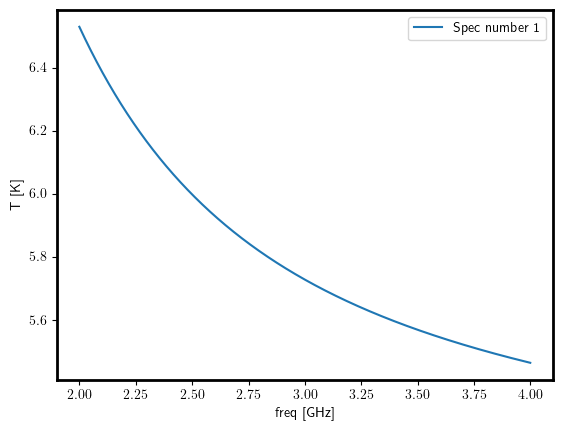

In [19]:
for i, spectrum in enumerate(spectra):
    plt.plot(freq,spectrum, label=f'Spec number {i+1}')
plt.xlabel('freq [GHz]')
plt.ylabel('T [K]')
plt.legend()
plt.show()
